В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

In [26]:
!pip install torch_geometric --quiet
!pip install nni --quiet

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

Импортируем необходимые библиотеки

In [27]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split

from torch_geometric.utils import dense_to_sparse

from itertools import combinations

from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed

# Custom imports
import sys
sys.path.insert(1, "../input/dependecies")

from Graph import Graph
from GCN import (
    GCN,
    SimpleGCN,
    SimpleGAT,
    CustomDataset,
    train_model_accuracy,
    train_model_diversity,
    get_positive_and_negative
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [28]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [29]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [30]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [33]:
models_dict = load_json_from_directory('third_dataset')

Посмотрю как распределена точность моделей

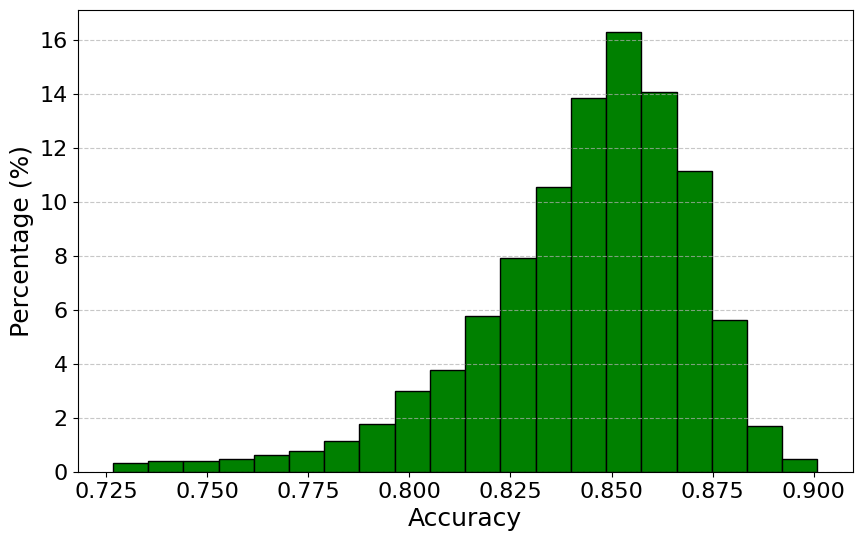

In [35]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green", weights=np.ones(len(accuracies))/len(accuracies)*100)
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Percentage (%)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
graph = Graph(models_dict[1])

Посмотрю как выглядит граф.

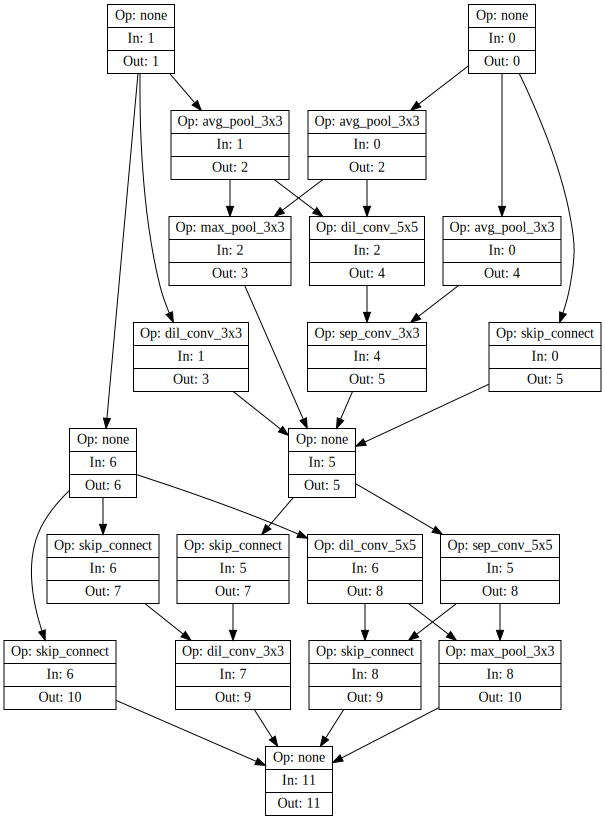

In [ ]:
graph.show_graph()

In [ ]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [ ]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: avg_pool_3x3 | In: 0 | Out: 2,
 Op: avg_pool_3x3 | In: 0 | Out: 4,
 Op: skip_connect | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: avg_pool_3x3 | In: 1 | Out: 2,
 Op: dil_conv_3x3 | In: 1 | Out: 3,
 Op: max_pool_3x3 | In: 2 | Out: 3,
 Op: dil_conv_5x5 | In: 2 | Out: 4,
 Op: sep_conv_3x3 | In: 4 | Out: 5]

In [ ]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: skip_connect | In: 0 | Out: 2,
 Op: sep_conv_5x5 | In: 0 | Out: 3,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: dil_conv_5x5 | In: 1 | Out: 3,
 Op: skip_connect | In: 1 | Out: 5,
 Op: dil_conv_3x3 | In: 2 | Out: 4,
 Op: skip_connect | In: 3 | Out: 4,
 Op: max_pool_3x3 | In: 3 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [ ]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [ ]:
def get_diversity(args):
    i, j, model_i, model_j = args
    preds_i = np.array(model_i["test_predictions"])
    preds_j = np.array(model_j["test_predictions"])
    distance = np.mean(preds_i == preds_j)
    return (i, j, distance)

def get_diversity_js(args):
    i, j, model_i, model_j, num_samples = args
    indices = np.random.choice(len(model_i["test_predictions"]), num_samples, replace=False)
    preds_i = np.array(model_i["test_predictions"])[indices]
    preds_j = np.array(model_j["test_predictions"])[indices]
    distance = np.mean([jensenshannon(p1, p2) for p1, p2 in zip(preds_i, preds_j)])
    return (i, j, distance)

Построю матрицу разнообразия

In [ ]:
def get_diversity_matrix_naive(models_dict, num_samples=None):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)

    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        if num_samples is not None:
            preds = preds[:num_samples]
        cached_preds[i] = preds

    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(cached_preds[i] == cached_preds[j])
            diversity_matrix[i, j] = distance
            diversity_matrix[j, i] = distance

    return diversity_matrix

def get_diversity_matrix_js(models_dict, num_samples=2000):
    n_models = len(models_dict)
    diversity_matrix = np.eye(n_models)
    
    cached_preds = {}
    for i in range(n_models):
        preds = np.array(models_dict[i]["test_predictions"])
        if num_samples is not None:
            preds = preds[:num_samples]
        cached_preds[i] = preds
    
    for i in tqdm(range(n_models), desc="Computing diversity matrix"):
        for j in range(i + 1, n_models):
            distance = np.mean(jensenshannon(cached_preds[i], cached_preds[j]))
            diversity_matrix[i, j] = distance
            diversity_matrix[j, i] = distance 

    return diversity_matrix

In [ ]:
diversity_matrix = get_diversity_matrix_js(models_dict)

Computing diversity matrix:   0%|          | 0/1300 [00:00<?, ?it/s]

  0%|          | 0/1300 [00:00<?, ?it/s]

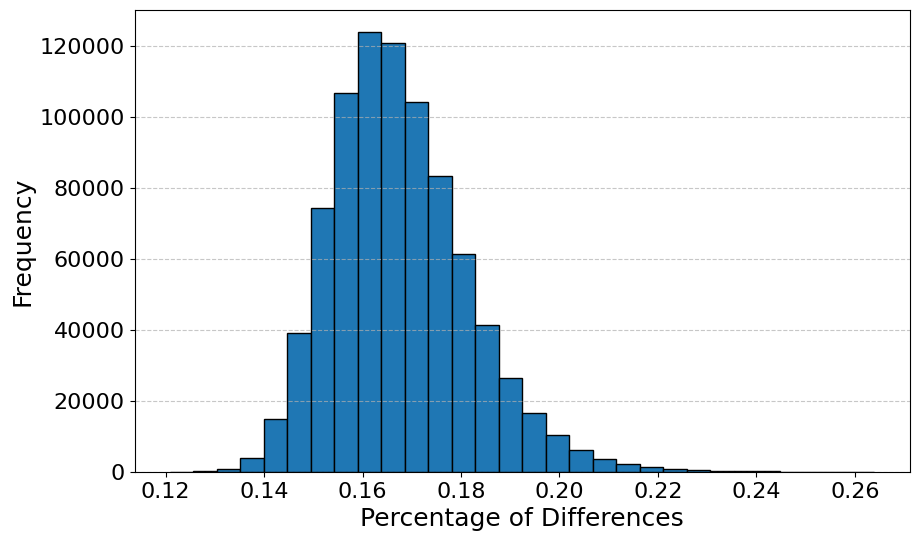

In [ ]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=30, edgecolor="black", weights=np.ones(len(diversities)) / len(diversities))
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Percentage", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
abort()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [ ]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.9, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.1, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [ ]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Строим тренировочный и валидационный датасеты.

In [ ]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
accuracies = [model['test_accuracy'] for model in models_dict]
graphs_dataset = CustomDataset(graphs, accuracies)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

100%|██████████| 1300/1300 [00:03<00:00, 424.45it/s]

Train dataset size: 1040
Test dataset size: 260


In [ ]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [ ]:
def extract_embeddings(model, dataset, device):
    model.to(device)
    model.eval()
    embeddings = []
    indices = []
    
    with torch.no_grad():
        for data in dataset:
            adj, features, index, _ = data
            
            # Перемещение данных на GPU (если используется)
            adj = adj.to(device)
            features = features.to(device)

            # Преобразование матрицы смежности в edge_index
            edge_index, _ = dense_to_sparse(adj)

            # Получение эмбеддинга графа
            embedding = model(features, edge_index)

            embeddings.append(embedding.cpu().numpy())
            indices.append(index)

    embeddings = np.vstack(embeddings)
    return embeddings, indices

Обучим модель предсказывать точность по архитектуре.

In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
embedding_dim = 64
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 1
num_epochs = 10

model_accuracy = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model_accuracy.parameters(), lr=2e-4)
criterion = nn.MSELoss()  

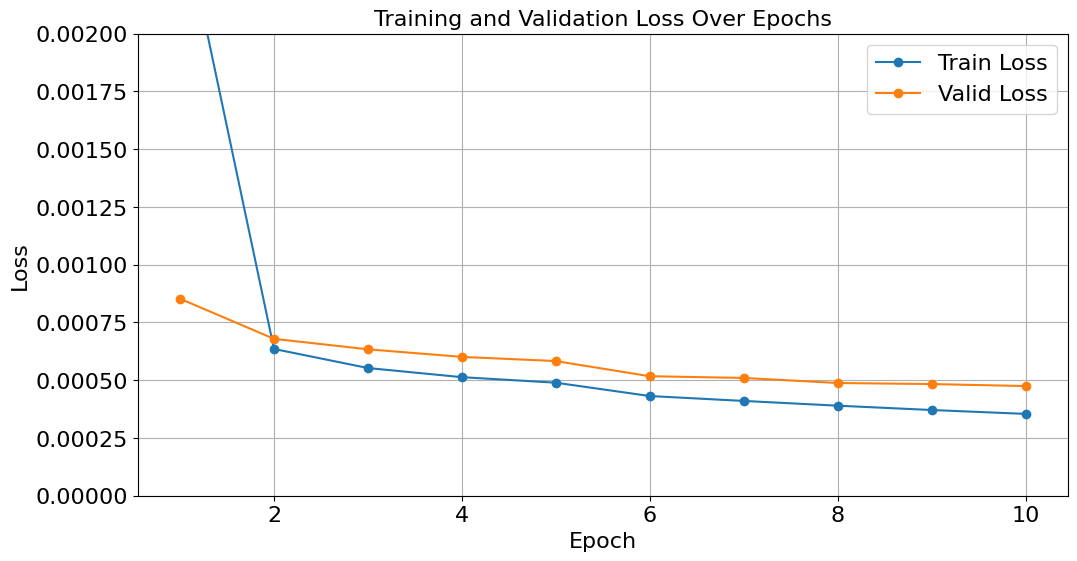

Training Progress: 100%|██████████| 10/10 [01:04<00:00,  6.50s/it]

Epoch 10, Train Loss: 0.0004, Valid Loss: 0.0005, LR: 0.000050


In [ ]:
train_model_accuracy(
    model_accuracy,
    train_dataset,
    valid_dataset,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False
);

In [ ]:
embeddings = extract_embeddings(model_accuracy, valid_dataset, device=device)[0]
for i, (adj, features, index, accuracy) in enumerate(valid_dataset):
    print(f"Index: {index:04d}, Accuracy: {accuracy.item():.3f}, Embedding: {embeddings[i][0]:.3f}")
    if i >= 20:
        break

Index: 0628, Accuracy: 0.750, Embedding: 0.798
Index: 0718, Accuracy: 0.897, Embedding: 0.877
Index: 0174, Accuracy: 0.850, Embedding: 0.860
Index: 1189, Accuracy: 0.850, Embedding: 0.851
Index: 1115, Accuracy: 0.803, Embedding: 0.816
Index: 1159, Accuracy: 0.860, Embedding: 0.856
Index: 1076, Accuracy: 0.850, Embedding: 0.853
Index: 0632, Accuracy: 0.854, Embedding: 0.851
Index: 0495, Accuracy: 0.865, Embedding: 0.852
Index: 0238, Accuracy: 0.814, Embedding: 0.839
Index: 0532, Accuracy: 0.827, Embedding: 0.849
Index: 1293, Accuracy: 0.857, Embedding: 0.867
Index: 0044, Accuracy: 0.870, Embedding: 0.874
Index: 1234, Accuracy: 0.830, Embedding: 0.854
Index: 1113, Accuracy: 0.804, Embedding: 0.826
Index: 0059, Accuracy: 0.828, Embedding: 0.860
Index: 0243, Accuracy: 0.785, Embedding: 0.838
Index: 0406, Accuracy: 0.836, Embedding: 0.811
Index: 0758, Accuracy: 0.782, Embedding: 0.797
Index: 0637, Accuracy: 0.806, Embedding: 0.833
Index: 1081, Accuracy: 0.744, Embedding: 0.812


In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 256  # Размерность скрытого слоя
output_dim = 16
num_epochs = 30

model = GCN(input_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=1)

Основной код обучения модели похожести.

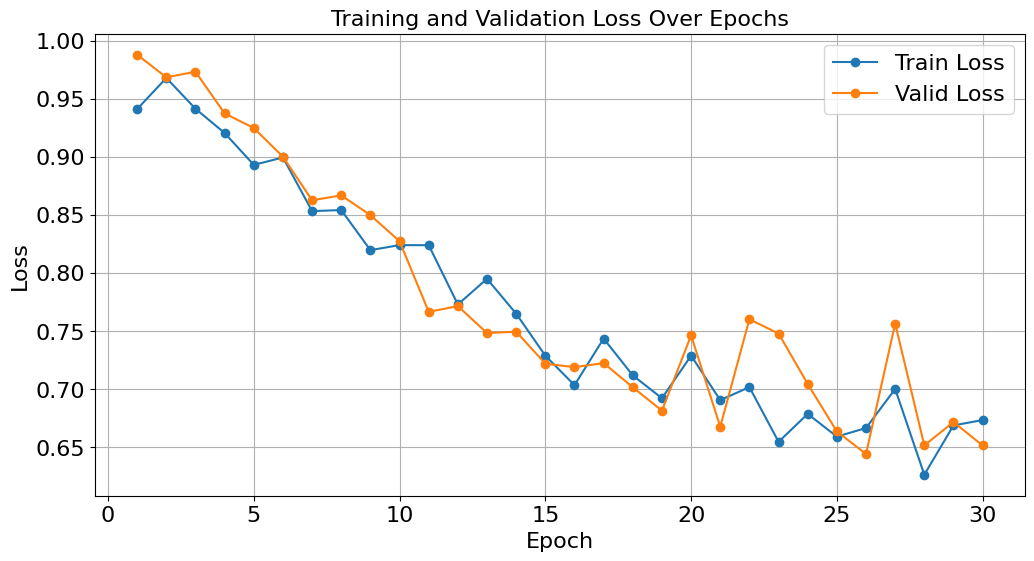

Training Progress: 100%|██████████| 30/30 [12:23<00:00, 24.78s/it]

Epoch 30, Train Loss: 0.6732, Valid Loss: 0.6513, LR: 0.000016


In [ ]:
train_model_diversity(
    model,
    train_dataset,
    valid_dataset,
    discrete_diversity_matrix,
    optimizer,
    criterion,
    num_epochs,
    device=device,
    developer_mode=False,
);

In [ ]:
def visualize_clusters(model, dataset, device="cpu", min_samples=3, xi=0.025, min_cluster_size=3):
  """
  Визуализирует кластеры, используя PCA для уменьшения размерности и OPTICS для кластеризации.

  Аргументы:
    model: Обученная модель для извлечения эмбеддингов.
    train_dataset: Датасет для обучения.
    device: Устройство для вычислений ("cpu" или "cuda").
    min_samples: Минимальное количество образцов для формирования кластера в OPTICS.
    xi: Параметр для определения устойчивости кластеров в OPTICS.
    min_cluster_size: Минимальный размер кластера в OPTICS.
  """
  # Извлечение эмбеддингов
  embeddings, indices = extract_embeddings(model, dataset, device=device)
  
  # Преобразование эмбеддингов в 2D с помощью PCA
  pca = PCA(n_components=2)
  embeddings_2d = pca.fit_transform(embeddings)

  # Кластеризация с помощью OPTICS
  optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size, metric="euclidean")
  clusters = optics.fit_predict(embeddings)

  # Визуализация кластеров
  plt.figure(figsize=(8, 6.5))
  scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=clusters, 
    cmap='tab10',  
    s=np.where(clusters == -1, 20, 70),  
    alpha=np.where(clusters == -1, 0.5, 1)
  )
  plt.xlabel("PCA Component 1", fontsize=16)
  plt.ylabel("PCA Component 2", fontsize=16)

  # Создание легенды для кластеров
  unique_clusters = np.unique(clusters)
  for cluster in unique_clusters:
    if cluster == -1:
      label = "Noise"
    else:
      label = f"Cluster {cluster}"
    plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label, s=50 if cluster != -1 else 20)

  plt.gca().set_facecolor('lightgrey')
  plt.show()

  return clusters

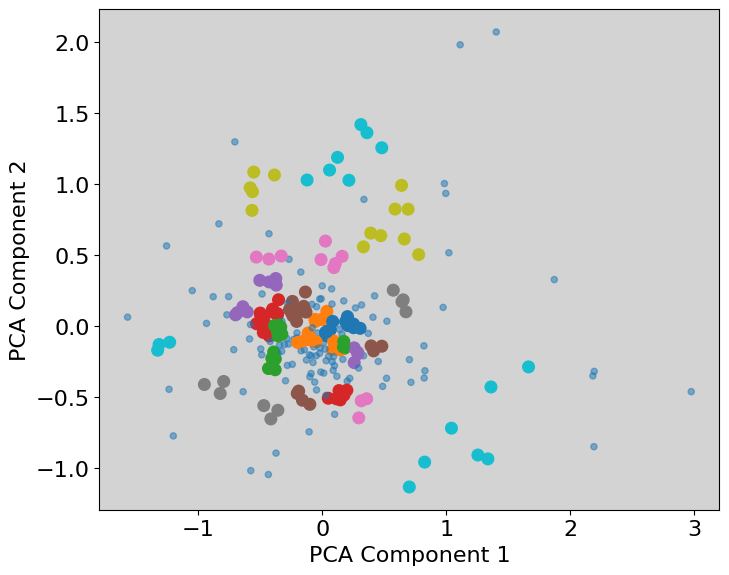

In [ ]:
clusters = visualize_clusters(
    model,
    valid_dataset,
    device=device,
    min_samples=3,
    xi=0.025,
    min_cluster_size=3
)

In [ ]:
torch.save(model.state_dict(), "model_diversity_weights.pth")
torch.save(model_accuracy.state_dict(), "model_accuracy_weights.pth")

In [ ]:
embeddings[0]

array([0.7975759], dtype=float32)

In [ ]:
max_cluster = np.max(clusters)
cluster_indexes = [np.where(clusters == i)[0] for i in range(max_cluster + 1)]
cluster_indexes = sorted(cluster_indexes, key=len, reverse=True)
cluster_indexes = cluster_indexes[0]
embeddings, indices = extract_embeddings(
model_accuracy,
graphs_dataset[cluster_indexes],
device=device,
)

for embedding, index in zip(embeddings, indices):
    print(f"acc_true: {valid_dataset[index][3]:.3f}, pred {embedding[0]:.3f}")

acc_true: 0.804, pred 0.840
acc_true: 0.851, pred 0.853
acc_true: 0.858, pred 0.851
acc_true: 0.854, pred 0.855
acc_true: 0.857, pred 0.846
acc_true: 0.836, pred 0.849
acc_true: 0.735, pred 0.849
acc_true: 0.761, pred 0.843
acc_true: 0.865, pred 0.846
acc_true: 0.853, pred 0.839


In [ ]:
def compute_correlation(models_dict, dataset, model, diversity_matrix, device="cpu"):
    model.to(device)
    model.eval()

    N = len(dataset)
    embeddings = []

    with torch.no_grad():
        for adj, features, index, _ in dataset:
            adj, features = adj.to(device), features.to(device)

            edge_index, _ = dense_to_sparse(adj)

            embedding = model(features, edge_index).cpu().numpy()
            embeddings.append(embedding)

    embeddings = np.array(embeddings)

    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")

    architectures = [models_dict[index] for index in dataset.indices]

    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N), desc="Computing similarity matrix"):
        for j in range(i + 1, N):
            arch_i_index = dataset[i][2]
            arch_j_index = dataset[j][2]
            
            similarity_matrix[i, j] = diversity_matrix[arch_i_index, arch_j_index]
            similarity_matrix[j, i] = similarity_matrix[i, j]

    triu_indices = np.triu_indices(N, k=1)

    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation, _ = pearsonr(embedding_distances, similarity_values)

    return correlation

Рассчитаю корреляции

In [ ]:
pearson_correlation = compute_correlation(models_dict, valid_dataset, model, diversity_matrix, device=device)

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")

Computing similarity matrix:   0%|          | 0/260 [00:00<?, ?it/s]

Корреляция Пирсона: -0.261


In [ ]:
def compute_cluster_mean_diversities(
    clusters: np.ndarray,
    diversity_matrix: np.ndarray,
    discrete_diversity_matrix: np.ndarray,
    min_samples: int = 10,
):
    """
    Для каждого кластера берёт «якорную» архитектуру (первый элемент кластера),
    затем в min_samples раз выбирает положительную и отрицательную архитектуры
    через get_positive_and_negative (по discrete_diversity_matrix),
    и усредняет заранее посчитанные отношения разнообразия из diversity_matrix.
    """
    n_clusters = len(set(clusters))
    
    for i in range(n_clusters):
        # индексы объектов, попавших в кластер i
        cluster_idxs = np.where(clusters == i)[0]
        if len(cluster_idxs) < 2:
            print(f"Cluster {i}: not enough samples.")
            continue
        
        anchor = cluster_idxs[0]
        pos_divs, neg_divs = [], []
        
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, anchor)
            if positive is None or negative is None:
                # пропускаем, если не удалось найти пару
                continue
            
            # вместо вызова get_diversity_js просто берём готовое значение
            pos_divs.append(diversity_matrix[anchor, positive])
            neg_divs.append(diversity_matrix[anchor, negative])
        
        mean_pos = np.mean(pos_divs) if pos_divs else None
        mean_neg = np.mean(neg_divs) if neg_divs else None
        
        print(f"Cluster {i}:")
        if mean_pos is not None:
            print(f"  Mean Positive Diversity: {mean_pos:.4f}")
        else:
            print("  No positive diversity data available.")
        
        if mean_neg is not None:
            print(f"  Mean Negative Diversity: {mean_neg:.4f}")
        else:
            print("  No negative diversity data available.")
        
        # ограничиваем вывод первыми 11 кластерами
        if i >= 10:
            break
            
compute_cluster_mean_diversities(
    clusters,
    diversity_matrix,
    discrete_diversity_matrix,
    min_samples=10,
)

Cluster 0:
  Mean Positive Diversity: 0.1928
  Mean Negative Diversity: 0.1656
Cluster 1:
  Mean Positive Diversity: 0.1820
  Mean Negative Diversity: 0.1553
Cluster 2:
  Mean Positive Diversity: 0.1908
  Mean Negative Diversity: 0.1492
Cluster 3:
  Mean Positive Diversity: 0.1879
  Mean Negative Diversity: 0.1556
Cluster 4:
  Mean Positive Diversity: 0.1943
  Mean Negative Diversity: 0.1568
Cluster 5:
  Mean Positive Diversity: 0.1854
  Mean Negative Diversity: 0.1496
Cluster 6:
  Mean Positive Diversity: 0.1911
  Mean Negative Diversity: 0.1500
Cluster 7:
  Mean Positive Diversity: 0.1912
  Mean Negative Diversity: 0.1597
Cluster 8:
  Mean Positive Diversity: 0.1910
  Mean Negative Diversity: 0.1546
Cluster 9:
  Mean Positive Diversity: 0.1902
  Mean Negative Diversity: 0.1613
Cluster 10:
  Mean Positive Diversity: 0.1863
  Mean Negative Diversity: 0.1460


In [ ]:
# Индексы кластеров
cluster_1_indexes = np.where(clusters == 1)[0]
cluster_2_indexes = np.where(clusters == 2)[0]

# ====== Средняя похожесть внутри первого кластера ======
n1 = len(cluster_1_indexes)
if n1 > 1:
    # Выбираем подматрицу diversity_matrix для кластер 1
    submat_1 = diversity_matrix[np.ix_(cluster_1_indexes, cluster_1_indexes)]
    # Берём только верхний треугольник без диагонали
    triu_i, triu_j = np.triu_indices(n1, k=1)
    sims_within_1 = submat_1[triu_i, triu_j]
    mean_similarity_within_cluster_1 = np.mean(sims_within_1)
else:
    mean_similarity_within_cluster_1 = None

# ====== Средняя похожесть между кластерами 1 и 2 ======
if len(cluster_1_indexes) > 0 and len(cluster_2_indexes) > 0:
    sims_between = diversity_matrix[np.ix_(cluster_1_indexes, cluster_2_indexes)]
    mean_similarity_between_clusters = np.mean(sims_between)
else:
    mean_similarity_between_clusters = None

# ====== Результаты ======
if mean_similarity_within_cluster_1 is not None:
    print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
else:
    print("В первом кластере недостаточно элементов для расчёта похожести.")

if mean_similarity_between_clusters is not None:
    print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")
else:
    print("Недостаточно элементов в одном из кластеров для расчёта межкластерной похожести.")

Средняя похожесть внутри первого кластера: 0.1602
Средняя похожесть между первым и вторым кластерами: 0.1674


In [ ]:
with open("logs.txt", "w", encoding="utf-8") as log:
    for index in cluster_1_indexes:
        tmp_graph = Graph(models_dict[index], index=index)
        for key, value in models_dict[index]["architecture"].items():
            log.write(f"{key}: {value}\n")
        log.write("\n")  # Добавляем пустую строку между архитектурами